In [1]:
import pandas as pd
import psycopg2 as pg
import pickle
import numpy as np
# visualization imports
import matplotlib.pyplot as plt
#import graphviz
from sklearn.datasets import *
from sklearn import tree
#import graphviz

import seaborn as sns
from collections import OrderedDict 


%matplotlib inline
from sklearn import linear_model

%pylab inline
%config InLineBackend.figure_formats=['retina']

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
#df_X=pd.read_csv('instacart_df_X_features_fnull.csv')
df_X=pd.read_csv('instacart_df_X_features_f.csv')

In [3]:
def get_user_split_data2(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_te = df_tr['in_cart'], df_te['in_cart']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','in_cart','aisle_id','department_id','user_most_recent_orderno_withprod','all_users_orders'],axis=1) 
    X_te = df_te.drop(['product_id','user_id','latest_cart','in_cart','aisle_id','department_id','user_most_recent_orderno_withprod','all_users_orders'],axis=1)

    return X_tr, X_te, y_tr, y_te

In [4]:
X_tr, X_te, y_tr, y_te = get_user_split_data2(df_X)
scaler = StandardScaler() #scales and brings it down to between 0 and 1, a quick transformation 
X_train_scaled = scaler.fit_transform(X_tr)
X_test_scaled = scaler.transform(X_te)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [5]:
lr = LogisticRegression(solver='liblinear') 
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear')
lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1}, solver='liblinear')

lr.fit(X_train_scaled, y_tr)
print('Normal Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr.predict(X_test_scaled)), roc_auc_score(y_te, lr.predict_proba(X_test_scaled)[:,1])))

lr_balanced.fit(X_train_scaled, y_tr)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr_balanced.predict(X_test_scaled)), roc_auc_score(y_te, lr_balanced.predict_proba(X_test_scaled)[:,1])))

lr_4x.fit(X_train_scaled, y_tr)
print('3:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, lr_4x.predict(X_test_scaled)), roc_auc_score(y_te, lr_4x.predict_proba(X_test_scaled)[:,1])))

Normal Logistic Regression Test F1: 0.143, Test AUC: 0.689
Balanced class weights Logistic Regression Test F1: 0.397, Test AUC: 0.690
3:1 class weights Logistic Regression Test F1: 0.400, Test AUC: 0.690


In [6]:
from sklearn import metrics
print("Precision:",metrics.precision_score(y_te, lr_4x.predict(X_test_scaled))) # 48/51
print("Recall:",metrics.recall_score(y_te, lr_4x.predict(X_test_scaled)))#48/54

Precision: 0.3050497637939733
Recall: 0.5804424662913994


In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_te, lr.predict_proba(X_test_scaled)[:,1])
fpr1, tpr1, thresholds = roc_curve(y_te, lr_balanced.predict_proba(X_test_scaled)[:,1])
fpr2, tpr2, thresholds = roc_curve(y_te, lr_4x.predict_proba(X_test_scaled)[:,1])

ROC AUC score =  0.6887187174056415
ROC AUC score =  0.6903777540311736
ROC AUC score =  0.6903218225760915


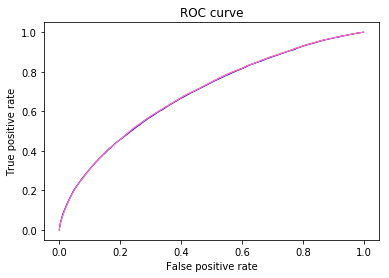

In [8]:
plt.plot(fpr, tpr,lw=1, c ='blue')
plt.plot(fpr1, tpr1,lw=1, c='red')
plt.plot(fpr2, tpr2,lw=1, c = 'violet')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_te, lr.predict_proba(X_test_scaled)[:,1]))
print("ROC AUC score = ", roc_auc_score(y_te, lr_balanced.predict_proba(X_test_scaled)[:,1]))
print("ROC AUC score = ", roc_auc_score(y_te, lr_4x.predict_proba(X_test_scaled)[:,1]))

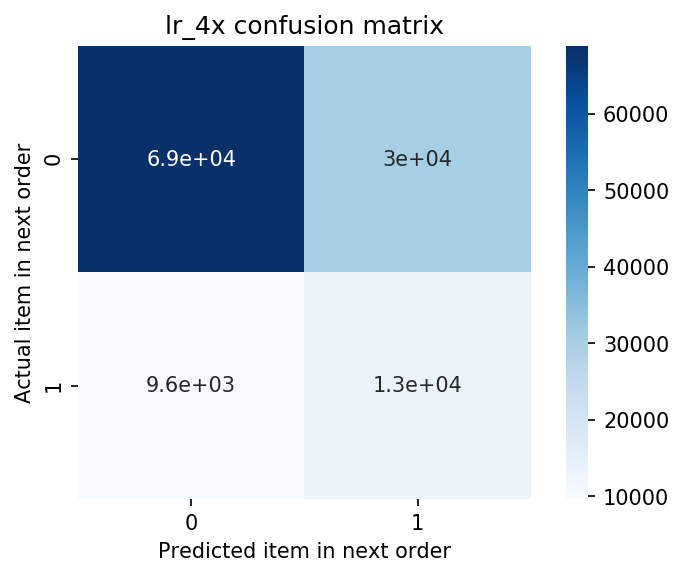

In [9]:
lr_4x_confusion = confusion_matrix(y_te, lr_4x.predict(X_test_scaled))
plt.figure(dpi=150)
sns.heatmap(lr_4x_confusion, cmap=plt.cm.Blues, annot=True, square=True)
         #  xticklabels=iris_dataset['target_names'],
          # yticklabels=iris_dataset['target_names)

plt.xlabel('Predicted item in next order')
plt.ylabel('Actual item in next order')
plt.title('lr_4x confusion matrix');    


In [10]:
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,...,21,user_product_avg_hour_of_day,user_product_avg_dow,most_recent_order_dow,most_recent_order_hour_of_day,user_product_avg_hod_delta,user_most_recent_orderno_withprod,all_users_orders,position_of_most_recent_order_cont_prod,pct_total_orders_contain_prod
0,1,1494,1,{44560},0,47,6.255319,1,21.0,21,...,0,8.0,2.0,2.717803,13.389522,5.389522,186761,[186761],1,1.0
1,1,1540,1,"{37600, 1, 11266, 3298, 130, 30720, 10310, 401...",1,47,6.255319,2,10.0,13,...,0,0.0,2.0,1.000000,1.000000,1.000000,200390,"[133972, 200390]",2,1.0
2,1,3904,1,"{6184, 20818, 21572, 32478}",0,47,6.255319,1,3.0,3,...,0,14.0,1.0,2.717803,13.389522,0.610478,207661,[207661],1,1.0
3,1,15182,1,"{1, 4210, 30731, 19511}",1,47,6.255319,2,2.5,3,...,0,19.0,1.0,0.000000,17.000000,2.000000,153011,"[153011, 173785]",1,0.5
4,1,26613,1,"{21288, 3265, 11759}",0,47,6.255319,2,3.5,7,...,0,12.0,6.0,2.717803,13.389522,1.389522,130646,"[130646, 182724]",1,0.5


In [11]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606292 entries, 0 to 606291
Data columns (total 45 columns):
product_id                                 606292 non-null int64
user_id                                    606292 non-null int64
user_product_total_orders                  606292 non-null int64
latest_cart                                606292 non-null object
in_cart                                    606292 non-null int64
product_total_orders                       606292 non-null int64
product_avg_add_to_cart_order              606292 non-null float64
user_total_orders                          606292 non-null int64
user_avg_cartsize                          606292 non-null float64
user_total_products                        606292 non-null int64
user_avg_days_since_prior_order            606292 non-null float64
user_product_avg_add_to_cart_order         606292 non-null float64
user_product_order_freq                    606292 non-null float64
aisle_id                         

In [ ]:
#want to plot ALL features, not a subset
# def plot_features(df, sample_size=500):
    
#     sample = (df.drop(['product_id','user_id','latest_cart'],axis=1)
#                 .sample(1000, random_state=44)) 
#     sns.pairplot(sample,hue='in_cart', plot_kws=dict(alpha=.3, edgecolor='none'))

# plot_features(df_X)

In [12]:
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,...,21,user_product_avg_hour_of_day,user_product_avg_dow,most_recent_order_dow,most_recent_order_hour_of_day,user_product_avg_hod_delta,user_most_recent_orderno_withprod,all_users_orders,position_of_most_recent_order_cont_prod,pct_total_orders_contain_prod
0,1,1494,1,{44560},0,47,6.255319,1,21.0,21,...,0,8.0,2.0,2.717803,13.389522,5.389522,186761,[186761],1,1.0
1,1,1540,1,"{37600, 1, 11266, 3298, 130, 30720, 10310, 401...",1,47,6.255319,2,10.0,13,...,0,0.0,2.0,1.000000,1.000000,1.000000,200390,"[133972, 200390]",2,1.0
2,1,3904,1,"{6184, 20818, 21572, 32478}",0,47,6.255319,1,3.0,3,...,0,14.0,1.0,2.717803,13.389522,0.610478,207661,[207661],1,1.0
3,1,15182,1,"{1, 4210, 30731, 19511}",1,47,6.255319,2,2.5,3,...,0,19.0,1.0,0.000000,17.000000,2.000000,153011,"[153011, 173785]",1,0.5
4,1,26613,1,"{21288, 3265, 11759}",0,47,6.255319,2,3.5,7,...,0,12.0,6.0,2.717803,13.389522,1.389522,130646,"[130646, 182724]",1,0.5


X_tr, X_te, y_tr, y_te = get_user_split_data2(df_X)
scaler = StandardScaler() #scales and brings it down to between 0 and 1, a quick transformation 
X_train_scaled = scaler.fit_transform(X_tr)
X_test_scaled = scaler.transform(X_te)

lr = LogisticRegression(C=1)
lr.fit(X_train_scaled, y_tr)
f1_score(y_te, lr.predict(X_test_scaled))

# Logistic regression class imbalance 

In [13]:
scores=cross_val_score(lr_4x, X_train_scaled, y_tr, cv=5,scoring='accuracy', n_jobs=-1)

In [14]:
scores.mean()

0.658462796878169

In [15]:
f1 = cross_val_score(lr_4x, 
            X_train_scaled, y_tr, scoring='f1', cv=5)

In [16]:
#f1 score!
f1.mean()

0.39372954130195953

In [17]:
#f1_score(y_te, y_predict)

In [18]:
lr_4x.fit(X_train_scaled, y_tr)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 4}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [19]:
y_predict = lr_4x.predict(X_test_scaled)

In [20]:
lr_4x.score(X_test_scaled,y_te)

0.673092514187911

In [21]:
f1_score(y_te, y_predict)

0.39992183154698374

In [22]:
with open("logr.pkl", 'rb') as picklefile: 
      logr = pickle.load(picklefile)

In [23]:
#logr

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_te, lr.predict_proba(X_test_scaled)[:,1])
fpr1, tpr1, thresholds = roc_curve(y_te, lr_balanced.predict_proba(X_test_scaled)[:,1])
fpr2, tpr2, thresholds = roc_curve(y_te, lr_4x.predict_proba(X_test_scaled)[:,1])

ROC AUC score =  0.6887187174056415
ROC AUC score =  0.6903777540311736
ROC AUC score =  0.6903218225760915


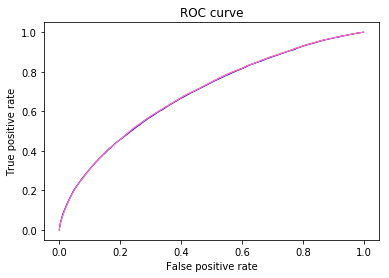

In [25]:
plt.plot(fpr, tpr,lw=1, c ='blue')
plt.plot(fpr1, tpr1,lw=1, c='red')
plt.plot(fpr2, tpr2,lw=1, c = 'violet')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_te, lr.predict_proba(X_test_scaled)[:,1]))
print("ROC AUC score = ", roc_auc_score(y_te, lr_balanced.predict_proba(X_test_scaled)[:,1]))
print("ROC AUC score = ", roc_auc_score(y_te, lr_4x.predict_proba(X_test_scaled)[:,1]))

In [ ]:
#y_predict = lr_4x.predict(X_train_scaled)  # This is a hard classifier

In [ ]:
#lr_4x.score(X_train_scaled,y_tr)

## Random Forest classifier

In [26]:
rfc=RandomForestClassifier(n_estimators=50,random_state=42,n_jobs=-1,)

In [27]:
rfc.fit(X_train_scaled, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [28]:
y_predict = rfc.predict(X_test_scaled)

In [29]:
rfc.score(X_train_scaled,y_tr)

1.0

In [30]:
rfc.score(X_test_scaled,y_te)

1.0

In [31]:
f1_score(y_te, y_predict)

1.0

In [32]:
X_tr.head()

,user_product_total_orders,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,1,...,19,20,21,user_product_avg_hour_of_day,user_product_avg_dow,most_recent_order_dow,most_recent_order_hour_of_day,user_product_avg_hod_delta,position_of_most_recent_order_cont_prod,pct_total_orders_contain_prod
2,1,47,6.255319,1,3.0,3,30.000000,2.0,1.00,0,...,1,0,0,14.0,1.0,2.717803,13.389522,0.610478,1,1.0
3,1,47,6.255319,2,2.5,3,2.200000,3.0,0.50,0,...,1,0,0,19.0,1.0,0.000000,17.000000,2.000000,1,0.5
5,1,47,6.255319,4,4.5,15,5.722222,1.0,0.25,0,...,1,0,0,15.0,5.0,2.717803,13.389522,1.610478,2,0.5
6,1,47,6.255319,1,23.0,23,11.000000,10.0,1.00,0,...,1,0,0,15.0,3.0,2.717803,13.389522,1.610478,1,1.0
8,1,47,6.255319,2,11.5,22,6.565217,9.0,0.50,0,...,1,0,0,16.0,3.0,2.717803,13.389522,2.610478,2,1.0


In [33]:
rfc.feature_importances_

array([5.22452072e-03, 4.85000062e-03, 6.74949945e-03, 1.27279166e-03,
       8.14069184e-04, 7.07028225e-04, 7.91752756e-04, 1.40093489e-03,
       4.01678327e-03, 2.85369499e-05, 1.90806213e-06, 2.60267769e-05,
       2.71082563e-04, 9.57191071e-06, 1.93030074e-05, 1.29966566e-04,
       1.11368403e-05, 2.71038479e-05, 3.74316965e-06, 5.31421603e-05,
       1.76403289e-05, 6.19371891e-04, 1.48600956e-05, 7.83508942e-05,
       2.83101378e-04, 7.87224638e-05, 1.01460510e-05, 3.23331732e-05,
       1.98419626e-05, 5.72184343e-06, 7.01962792e-03, 3.66441691e-04,
       4.09818111e-01, 5.03833627e-01, 4.98658532e-02, 7.20581743e-04,
       8.06764871e-04])

In [34]:
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), X_tr.columns), 
             reverse=True))

Features sorted by their score:
[(0.5038, 'most_recent_order_hour_of_day'), (0.4098, 'most_recent_order_dow'), (0.0499, 'user_product_avg_hod_delta'), (0.007, 'user_product_avg_hour_of_day'), (0.0067, 'product_avg_add_to_cart_order'), (0.0052, 'user_product_total_orders'), (0.0049, 'product_total_orders'), (0.004, 'user_product_order_freq'), (0.0014, 'user_product_avg_add_to_cart_order'), (0.0013, 'user_total_orders'), (0.0008, 'user_avg_days_since_prior_order'), (0.0008, 'user_avg_cartsize'), (0.0008, 'pct_total_orders_contain_prod'), (0.0007, 'user_total_products'), (0.0007, 'position_of_most_recent_order_cont_prod'), (0.0006, '13'), (0.0004, 'user_product_avg_dow'), (0.0003, '4'), (0.0003, '16'), (0.0001, '7'), (0.0001, '17'), (0.0001, '15'), (0.0001, '11'), (0.0, '9'), (0.0, '8'), (0.0, '6'), (0.0, '5'), (0.0, '3'), (0.0, '21'), (0.0, '20'), (0.0, '2'), (0.0, '19'), (0.0, '18'), (0.0, '14'), (0.0, '12'), (0.0, '10'), (0.0, '1')]


In [35]:
df_X.drop(columns=['most_recent_order_hour_of_day','most_recent_order_dow','user_product_avg_hod_delta'],inplace=True)

In [ ]:
####validation set

# X_tr, X_te, y_tr, y_te = get_user_split_data2(df_X)
# X_tr1, X_val, y_tr1, y_val=get_user_split_data2(X_tr, y_tr)
# scaler = StandardScaler() #scales and brings it down to between 0 and 1, a quick transformation 
# X_train_scaled = scaler.fit_transform(X_tr1)
# X_vale_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_te)

In [ ]:
#rfc=RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)

In [ ]:
#rfc.fit(X_train_scaled, y_tr)

In [ ]:
#y_predict = rfc.predict(X_test_scaled)

In [ ]:
#rfc.score(X_train_scaled,y_tr)

In [ ]:
#f1_score(y_te, y_predict)

In [ ]:
# print ("Features sorted by their score:")
# print (sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), X_tr.columns), 
#              reverse=True))

In [36]:
df_X.drop(columns=['1' ,'10', '11', '12', '14','15','18','19','2','20','21','3','5','6','8','9'],inplace=True)

In [37]:
X_tr, X_te, y_tr, y_te = get_user_split_data2(df_X)
scaler = StandardScaler() #scales and brings it down to between 0 and 1, a quick transformation 
X_train_scaled = scaler.fit_transform(X_tr)
X_test_scaled = scaler.transform(X_te)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [ ]:
#x_tr.head()

In [ ]:
#rfc=RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)

In [ ]:
#rfc.fit(X_train_scaled, y_tr)

In [ ]:
#y_predict = rfc.predict(X_test_scaled)

In [ ]:
#rfc.score(X_train_scaled,y_tr)

In [ ]:
#f1_score(y_te, y_predict)

# Random forest classifier using min samples split

In [38]:
rfc_4x = RandomForestClassifier(n_estimators=220, min_samples_split=400,random_state=42,n_jobs=-1, class_weight= 'balanced')

In [39]:
rfc_4x.fit(X_train_scaled, y_tr)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=400, min_weight_fraction_leaf=0.0,
            n_estimators=220, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [40]:
y_predict = rfc_4x.predict(X_test_scaled)

In [41]:
rfc_4x.score(X_train_scaled,y_tr)

0.6890006010149097

In [42]:
f1_score(y_te, y_predict)

0.3979158220340255

In [43]:
from sklearn.metrics import precision_score, recall_score,auc

print("Precision:", precision_score(y_te, y_predict))
print("Recall:",recall_score(y_te, y_predict))

Precision: 0.3033424908424908
Recall: 0.5781734083867871


In [ ]:
#print("Precision:",metrics.precision_score(y_te, lr_4x.predict(X_test_scaled))) # 48/51
#print("Recall:",metrics.recall_score(y_te, lr_4x.predict(X_test_scaled)))#48/54

In [ ]:
#auc = metrics.auc(recall_score(y_te, y_predict), precision_score(y_te, y_predict))

In [47]:
X_tr

,user_product_total_orders,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,4,7,13,16,17,user_product_avg_hour_of_day,user_product_avg_dow,position_of_most_recent_order_cont_prod,pct_total_orders_contain_prod
2,1,47,6.255319,1,3.000000,3,30.000000,2.0,1.000000,0,0,0,0,0,14.0,1.0,1,1.000000
3,1,47,6.255319,2,2.500000,3,2.200000,3.0,0.500000,0,0,0,0,0,19.0,1.0,1,0.500000
5,1,47,6.255319,4,4.500000,15,5.722222,1.0,0.250000,0,0,0,0,0,15.0,5.0,2,0.500000
6,1,47,6.255319,1,23.000000,23,11.000000,10.0,1.000000,0,0,0,0,0,15.0,3.0,1,1.000000
8,1,47,6.255319,2,11.500000,22,6.565217,9.0,0.500000,0,0,0,0,0,16.0,3.0,2,1.000000
9,2,47,6.255319,5,3.600000,9,11.055556,3.0,0.400000,0,0,0,0,0,11.5,4.5,2,0.400000
10,1,47,6.255319,2,10.000000,18,7.200000,8.0,0.500000,0,0,0,0,0,13.0,4.0,2,1.000000
11,2,47,6.255319,2,24.500000,34,7.000000,10.5,1.000000,0,0,0,0,0,10.0,1.0,2,1.000000
12,1,47,6.255319,1,2.000000,2,5.000000,2.0,1.000000,0,0,0,0,0,14.0,1.0,1,1.000000
14,1,47,6.255319,3,4.666667,14,16.071429,3.0,0.333333,0,0,0,0,0,17.0,2.0,2,0.666667


In [44]:
confusion_matrix(y_te, y_predict)

array([[68764, 30430],
       [ 9667, 13250]])

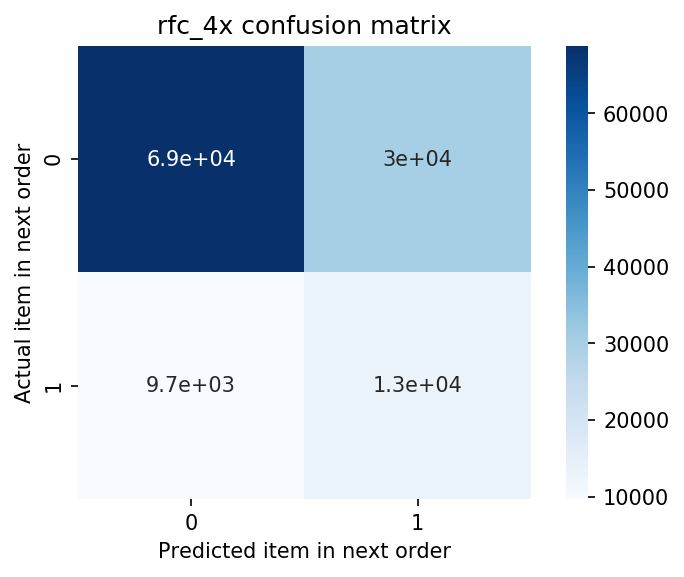

In [45]:
rfc_4x_confusion = confusion_matrix(y_te, rfc_4x.predict(X_test_scaled))
plt.figure(dpi=150)
sns.heatmap(rfc_4x_confusion, cmap=plt.cm.Blues, annot=True, square=True)
         #  xticklabels=iris_dataset['target_names'],
          # yticklabels=iris_dataset['target_names)

plt.xlabel('Predicted item in next order')
plt.ylabel('Actual item in next order')
plt.title('rfc_4x confusion matrix');    


In [46]:
import pickle

with open("rf.pkl", "wb") as f:
    pickle.dump(rfc_4x, f)

In [ ]:
rfc_4x

In [ ]:
df_X.head()

In [ ]:
df_X.info()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(rfc_4x.predict(X_te), y_te)

# XGBOOST

In [ ]:
##test train split
X_tr, X_te, y_tr, y_te = get_user_split_data2(df_X)

#scaler = StandardScaler() #scales and brings it down to between 0 and 1, a quick transformation 
#X_train_scaled = scaler.fit_transform(X_tr)
#X_test_scaled = scaler.transform(X_te)

In [ ]:
X_tr1, X_val, y_tr1, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler() #scales and brings it down to between 0 and 1, a quick transformation 
X_train_scaled = scaler.fit_transform(X_tr)
X_train1_scaled = scaler.fit_transform(X_tr1)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.transform(X_te)

In [ ]:
# def get_user_split_data3(df, test_size=.2, seed=42):

#     rs = np.random.RandomState(seed)
    
#     total_users = df['user_id'].unique() 
#     test_users = rs.choice(total_users, 
#                            size=int(total_users.shape[0] * test_size), 
#                            replace=False)
#     test_users1 = rs.choice(total_users, 
#                            size=int(total_users.shape[0] * test_size), 
#                            replace=False)
    

#     df_tr = df[~df['user_id'].isin(test_users)]
#     df_te = df[df['user_id'].isin(test_users)] 

#     y_tr, y_te = df_tr['in_cart'], df_te['in_cart']
#     X_tr = df_tr.drop(['product_id','user_id','latest_cart','in_cart','aisle_id','department_id','user_most_recent_orderno_withprod','all_users_orders'],axis=1) 
#     X_te = df_te.drop(['product_id','user_id','latest_cart','in_cart','aisle_id','department_id','user_most_recent_orderno_withprod','all_users_orders'],axis=1)

#     return X_tr, X_te, y_tr, y_te

In [ ]:
import xgboost as xgb

sns.set_style("whitegrid")
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="binary:logistic",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train1_scaled,y_tr1),(X_val_scaled,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train1_scaled, y_tr1, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )
#rmse=(gbm.predict(X_test_scaled, ntree_limit=gbm.best_ntree_limit),y_te) 

In [ ]:
y_pred = gbm.predict(X_test_scaled, ntree_limit=gbm.best_ntree_limit)
print (metrics.roc_auc_score(y_te,y_pred))

In [ ]:
#ROUND 2

In [ ]:
import xgboost as xgb

sns.set_style("whitegrid")
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=4,
                       objective="binary:logistic",
                       learning_rate=.2, 
                       subsample=1,
                       min_child_weight=5,
                       colsample_bytree=.8
                      )

eval_set=[(X_train1_scaled,y_tr1),(X_val_scaled,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train1_scaled, y_tr1, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=100,
                    verbose=True #gives output log as below
                   )
#rmse=(gbm.predict(X_test_scaled, ntree_limit=gbm.best_ntree_limit),y_te) 

In [ ]:
y_pred = gbm.predict(X_test_scaled, ntree_limit=gbm.best_ntree_limit)
print (metrics.roc_auc_score(y_te,y_pred))

In [ ]:
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1,class_weight={0:1,1:2})

random_forest.fit(X_train_scaled, y_tr)
Y_prediction = random_forest.predict(X_test_scaled)

random_forest.score(X_train_scaled, y_tr)

In [ ]:
f1_score(y_te, Y_prediction)

In [ ]:
rfc=RandomForestClassifier(n_estimators=100,random_state=42, max_depth=2,n_jobs=-1)

In [ ]:
rfc.fit(X_train_scaled, y_tr)

In [ ]:
rfc.score(X_test_scaled,y_te)

In [ ]:
f1_score(y_te, rfc.predict(X_test_scaled))

In [ ]:
y_predict = rfc.predict(X_train_scaled)

In [ ]:
#y_predict = rfc.predict(X_test_scaled)

In [ ]:
meanSquaredError=mean_squared_error(y_tr, y_predict)
print("MSE:", meanSquaredError)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
meanSquaredError=mean_squared_error(y_te, y_predict)
print("MSE:", meanSquaredError)

In [ ]:
rfc=RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1)

In [ ]:
rfc.fit(X_train_scaled, y_tr)

In [ ]:
rfc.score(X_test_scaled,y_te)

In [ ]:
f1_score(y_te, rfc.predict(X_test_scaled))

In [ ]:
#y_predict = rfc.predict(X_test_scaled)

In [ ]:
y_predict = rfc.predict(X_train_scaled)

In [ ]:
meanSquaredError=mean_squared_error(y_tr, y_predict)
print("MSE:", meanSquaredError)

In [ ]:
import pickle

with open("lr.pkl", "wb") as f:
    pickle.dump(lr, f)

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
lr.get_feature_names()

In [ ]:
lr_4x.predict_proba()

In [ ]:
lr_4x.coef_, lr_4x.intercept_

In [ ]:
y_pred = lr_4x.predict(X_test_scaled)                             # Predicted class labels from test features
y_predicted_proba = lr_4x.predict_proba(X_test_scaled)   

In [ ]:
y_predicted_proba #first column, prob of class 0, second column probability of class 1

In [ ]:
y_pred

In [ ]:
df_X.info()

In [ ]:
X_tr.info()